# L1 and L2 regularization for feature selection

 ### Are all variables (features) in a dataset truly relevant?
Muhammad Hilmi, Vitor Neves, Muhammad Talha Siddique, David Odd Erik Fürst Standal, Harald Taxt Walnum, Matija Zuza, Clemens Sundby Øxnevad

### The Troubles in Feature Selection and Model Training

- **Overfitting**: If too many features are included, models can fit the noise instead of the signal.  
- **Multicollinearity**: highly correlated features make coefficients unstable and hard to interpret (Do I hear PCA?).  
- **High-dimensional data**: when features >> samples, generalization can become difficult.  

👉 These challenges make it hard to identify which features are truly important.



### What is Regularization?

- Regularization is a technique to **prevent overfitting** by adding a **penalty** on large model weights.  
- It forces the model to stay simple, reducing variance and improving generalization.  

  $\text{Loss}=\text{Error term}+\lambda\cdot\text{Penalty on weights},$



### L1 and L2 Regularization

#### L1 Regularization (LASSO)
- Penalty: sum of absolute values of weights.  
- Encourages **sparsity** → many coefficients become exactly zero.   

The cost function is:

$$
\text{Cost}_{L1} = \sum_{i=1}^N \Big(y_i - \sum_{j=1}^M x_{ij} w_j \Big)^2 + \lambda \sum_{j=1}^M |w_j|
$$

**Advantages**  
- Automatic feature selection → simpler models.  
- Useful when only a subset of features truly matter (high-dimensional settings).  
- More robust to outliers than L2 (linear growth of |w|).  

**Disadvantages**  
- Can be unstable with highly correlated features.  
- No closed-form solution; needs iterative solvers.  
- If it zeros out useful predictors, variance can increase and performance can suffer.  


#### L2 Regularization (Ridge)
- Penalty: sum of squared weights.  
- Shrinks weights smoothly but rarely to zero.  
- Keeps all features but reduces their influence (no feature selection).

The cost function is:

$$
\text{Cost}_{L2} = \sum_{i=1}^N \Big(y_i - \sum_{j=1}^M x_{ij} w_j \Big)^2 + \lambda \sum_{j=1}^M w_j^2
$$

**Advantages**  
- Stable with multicollinearity (shares weight across correlated predictors).  
- Tends to reduce variance when many features have small effects.  
- Strictly convex objective → unique solution and often simpler optimization.  

**Disadvantages**  
- No feature selection (non-sparse); all variables remain in the model.  
- Less robust to outliers (squared growth of w²).  

### 🔹 Comparison of L1 and L2 Regularization

| Aspect                        | L1 Regularization (LASSO)                                                                 | L2 Regularization (Ridge)                                                              |
|--------------------------------|-------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| **Penalty term**              | $\lambda \sum_{j=1}^M |w_j|$                                                              | $\lambda \sum_{j=1}^M w_j^2$                                                            |
| **Effect on coefficients**    | Many $w_j$ shrink to **exactly 0** → sparse solution (feature selection).                  | All $w_j$ shrink smoothly toward 0, but rarely become exactly 0 (no feature selection). |
| **Model sparsity**            | ✅ Produces sparse models (automatic variable selection).                                   | ❌ Non-sparse (keeps all features).                                                     |
| **Handling multicollinearity**| Can be unstable if predictors are highly correlated (may arbitrarily pick one).             | More stable with correlated features (distributes weights among them).                  |
| **Robustness to outliers**    | More robust (absolute value grows linearly).                                               | Less robust (squared term grows faster).                                                |
| **Solution uniqueness**       | May have multiple equally good sparse solutions.                                           | Always gives a unique solution (strict convexity).                                      |


### Elastic Net Regularization (Best of both worlds?)

Elastic Net combines **L1** and **L2** penalties into a single loss function:

$$
\text{Cost}_{EN} = \text{Error term} + \lambda \left[ \alpha \sum_{j=1}^M |w_j| + (1-\alpha) \sum_{j=1}^M w_j^2 \right]
$$

- $\lambda$: overall regularization strength  
- $\alpha$: mixing parameter  
  - $\alpha = 1 \;\;\Rightarrow\;$ pure L1 (LASSO)  
  - $\alpha = 0 \;\;\Rightarrow\;$ pure L2 (Ridge)  
  - $0 < \alpha < 1 \;\;\Rightarrow\;$ blend of both  

- Combines the strengths of **L1 (feature selection)** and **L2 (stability with correlated predictors)**.  
- Flexible: the mixing parameter $\alpha$ allows tuning between sparsity (closer to L1) and smooth shrinkage (closer to L2).  
- Requires tuning of **two hyperparameters**.  



# Examples

In [ ]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, lasso_path, ElasticNet, enet_path
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)

# import sklearn, sys


sns.set_context("talk")
sns.set_style("whitegrid")

# RMSE helper
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

In [ ]:
# Data generation utilities
from typing import List

def make_block_correlated_X(n: int = 200, p: int = 100, block_size: int = 20, rho: float = 0.8, rng=None):
    rng = np.random.default_rng(rng)
    assert p % block_size == 0
    n_blocks = p // block_size
    X = np.empty((n, p))
    for b in range(n_blocks):
        z = rng.normal(size=(n, 1))  # latent factor per block
        eps = rng.normal(size=(n, block_size))
        block = rho * z + np.sqrt(1 - rho**2) * eps
        X[:, b*block_size:(b+1)*block_size] = block
    return X


def make_sparse_beta(p: int, block_size: int, n_blocks: int, nonzero_per_block: int = 1, beta_scale: float = 3.0, rng=None):
    rng = np.random.default_rng(rng)
    beta = np.zeros(p)
    for b in range(n_blocks):
        idxs = np.arange(b*block_size, (b+1)*block_size)
        nz = rng.choice(idxs, size=nonzero_per_block, replace=False)
        signs = rng.choice([-1, 1], size=nonzero_per_block)
        beta[nz] = signs * (beta_scale * rng.uniform(0.7, 1.3, size=nonzero_per_block))
    return beta

# Dataset 1: sparse, favouring Lasso
def simulate_regression_sparse(n=200, p=100, block_size=20, rho=0.8, snr=3.0, rng=123, nonzero_per_block=1):
    rng = np.random.default_rng(rng)
    X = make_block_correlated_X(n=n, p=p, block_size=block_size, rho=rho, rng=rng)
    n_blocks = p // block_size
    beta = make_sparse_beta(p=p, block_size=block_size, n_blocks=n_blocks, nonzero_per_block=nonzero_per_block, beta_scale=3.0, rng=rng)
    y_signal = X @ beta
    sigma = np.std(y_signal) / snr
    noise = rng.normal(scale=sigma, size=n)
    y = y_signal + noise
    return X, y, beta

# Dataset 2: dense/grouped truth favoring Ridge
def simulate_regression_dense_grouped(n=200, p=100, block_size=20, rho=0.8, snr=2.5, tau=1.0, rng=321):
    rng = np.random.default_rng(rng)
    X = make_block_correlated_X(n=n, p=p, block_size=block_size, rho=rho, rng=rng)
    n_blocks = p // block_size
    gamma = rng.normal(loc=0.0, scale=tau, size=n_blocks)
    beta = np.zeros(p)
    for b in range(n_blocks):
        idxs = np.arange(b*block_size, (b+1)*block_size)
        beta[idxs] = gamma[b] / np.sqrt(block_size)
    y_signal = X @ beta
    sigma = np.std(y_signal) / snr
    noise = rng.normal(scale=sigma, size=n)
    y = y_signal + noise
    return X, y, beta

# simulate once
n, p, block_size, rho, snr = 100, 50, 10, 0.8, 3.0
X_s, y_s, beta_true_s = simulate_regression_sparse(n=n, p=p, block_size=block_size, rho=rho, snr=snr, rng=123, nonzero_per_block=3)
print("X shape:", X_s.shape, " y shape:", y_s.shape)
print("Nonzero in true beta:", np.count_nonzero(beta_true_s))

X shape: (100, 50)  y shape: (100,)
Nonzero in true beta: 15


## Example 1: Sparse dataset
- 50 features, divided into 5 blocks
- Within each block, the features are highly correlated
- Only one feature per block is active ($\beta \neq 0$)

$$
 y = X\,\beta + \epsilon,\quad \epsilon\sim\mathcal N\!\left(0,\,\sigma^2 \right)
$$


<Axes: >

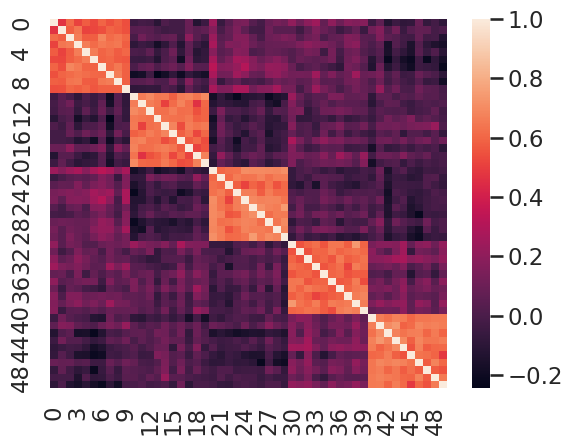

In [ ]:
sns.heatmap(pd.DataFrame(data=X_s).corr())

## CV analysis: tuning curves & RMSE distributions
K-fold CV on the full dataset

- **Lasso/Ridge**: grid over $\lambda$ (log-scale).
- **Elastic Net**: grid over $\lambda$ (log-scale) and $\alpha$
- **PLS**: grid over number of components $n_\text{c}$.


In [ ]:
def analyse_tuning_curves(
    X,
    y,
    cv,
    lambda_grid=np.logspace(-3, 2, 25),
    alpha_grid = [0.1, 0.3, 0.5, 0.7, 0.9],
    n_pls_comps=list(range(1, 30))
):

    records = []  # store per-fold RMSE for each (model, hyperparam)

    # Lasso
    for l in lambda_grid:
        pipe = Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=l, max_iter=5000, random_state=42))])
        for tr, va in cv.split(X):
            pipe.fit(X[tr], y[tr])
            pred = pipe.predict(X[va])
            records.append({"model": "Lasso", "param": "lambda", "value": l, "fold_rmse": rmse(y[va], pred)})

    # Ridge
    for l in lambda_grid:
        pipe = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=l, random_state=42))])
        for tr, va in cv.split(X):
            pipe.fit(X[tr], y[tr])
            pred = pipe.predict(X[va])
            records.append({"model": "Ridge", "param": "lambda", "value": l, "fold_rmse": rmse(y[va], pred)})

    # Elastic net
    for lr in alpha_grid:
        for l in lambda_grid:
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("model", ElasticNet(alpha=l, l1_ratio=lr, max_iter=5000, random_state=42))
            ])
            for tr, va in cv.split(X):
                pipe.fit(X[tr], y[tr])
                pred = pipe.predict(X[va])
                records.append({
                    "model": "ElasticNet",
                    "param": "lambda", "l1_ratio": lr, "value": l,
                    "fold_rmse": rmse(y[va], pred)
                })


    # PLS (scale=False inside, we handle scaling in pipeline)
    for nc in n_pls_comps:
        pipe = Pipeline([("scaler", StandardScaler()), ("model", PLSRegression(n_components=nc, scale=False))])
        for tr, va in cv.split(X):
            pipe.fit(X[tr], y[tr])
            pred = pipe.predict(X[va]).ravel()
            records.append({"model": "PLS", "param": "n_components", "value": nc, "fold_rmse": rmse(y[va], pred)})

    cv_df = pd.DataFrame(records)
    cv_df["log10_value"] = np.where(cv_df["param"]=="lambda", np.log10(cv_df["value"]), cv_df["value"])  # for nicer axes

    # Summaries of best settings by model
    best_summary = (cv_df.groupby(["model", "value"], as_index=False)
                        .agg(mean_rmse=("fold_rmse", "mean"), sd_rmse=("fold_rmse", "std")))
    idx = best_summary.groupby("model")["mean_rmse"].idxmin()
    best_by_model = best_summary.loc[idx].reset_index(drop=True)
    print(best_by_model)
    return cv_df

def _agg_mean_sd(sub: pd.DataFrame) -> pd.DataFrame:
    """Group by 'value' and compute mean±sd of fold RMSE."""
    if sub.empty:
        return pd.DataFrame(columns=["value", "mean_rmse", "sd_rmse"])
    out = (sub.groupby("value", as_index=False)
              .agg(mean_rmse=("fold_rmse", "mean"),
                   sd_rmse=("fold_rmse", "std"))
              .sort_values("value"))
    return out

def _enet_best_per_alpha(cv_df: pd.DataFrame) -> pd.DataFrame:
    """
    For Elastic Net: for each alpha (value), pick the l1_ratio with the lowest mean CV-RMSE.
    Return DataFrame with: value (alpha), log10_alpha, best_l1_ratio, mean_rmse, sd_rmse.
    """
    sub = cv_df[(cv_df["model"] == "ElasticNet")]
    required_cols = {"model", "value", "l1_ratio", "fold_rmse"}
    if sub.empty or not required_cols.issubset(sub.columns):
        return pd.DataFrame(columns=["value", "log10_alpha", "best_l1_ratio", "mean_rmse", "sd_rmse"])

    # Mean by (alpha, l1_ratio)
    mean_by_pair = (sub.groupby(["value", "l1_ratio"], as_index=False)
                       .agg(mean_rmse=("fold_rmse", "mean")))

    # For each alpha, choose the l1_ratio with the minimal mean RMSE
    idx = mean_by_pair.groupby("value")["mean_rmse"].idxmin()
    best_rows = mean_by_pair.loc[idx].sort_values("value").reset_index(drop=True)

    # Compute sd across folds for the chosen (alpha, l1_ratio*) pairs
    sd_list = []
    for _, r in best_rows.iterrows():
        a, lr = r["value"], r["l1_ratio"]
        mask = (sub["value"] == a) & (sub["l1_ratio"] == lr)
        sd_list.append(sub.loc[mask, "fold_rmse"].std())

    best_rows["sd_rmse"] = sd_list
    best_rows["log10_alpha"] = np.log10(best_rows["value"])
    best_rows = best_rows.rename(columns={"l1_ratio": "best_l1_ratio"})
    return best_rows[["value", "log10_alpha", "best_l1_ratio", "mean_rmse", "sd_rmse"]]


def add_enet_l1ratio_topline(ax, best_en, height_frac=0.22, color='tab:red'):
    """
    Adds a small shared-x axis above 'ax' that plots best l1_ratio vs log10(alpha).
    """
    # Compute the rectangle for a new axis just above ax
    fig = ax.figure
    box = ax.get_position()
    top_height = box.height * height_frac
    main_height = box.height * (1 - height_frac - 0.05)

    # shrink main ax to make room for the top line
    ax.set_position([box.x0, box.y0, box.width, main_height])

    ax_top = fig.add_axes([box.x0, box.y0 + main_height + 0.02, box.width, top_height], sharex=ax)
    x = best_en['log10_alpha'].values
    y = best_en['best_l1_ratio'].values
    ax_top.step(x, y, where='post', color=color, lw=2)
    ax_top.plot(x, y, marker='o', color=color, ls='None')

    ax_top.set_ylim(-0.02, 1.02)
    ax_top.set_yticks([0, 0.5, 1.0]); ax_top.set_ylabel('l1')
    ax_top.grid(True, axis='y', alpha=0.3)
    # Hide top axis x labels (they remain on ax below)
    for label in ax_top.get_xticklabels():
        label.set_visible(False)


def overlay_enet_l1ratio_line(ax, best_en, color='tab:red', lw=2, marker='o'):
    """
    Overlay best l1_ratio (in [0,1]) as a line/step on a twin y-axis (right side),
    sharing the x with the primary axis ax (RMSE axis).

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Primary axis (RMSE). Draw your RMSE curve and grid on this axis.
    best_en : DataFrame with columns ['log10_alpha','best_l1_ratio','mean_rmse','sd_rmse']
        Output of your _enet_best_per_alpha(...) step.
    """
    ax2 = ax.twinx()
    x = best_en['log10_alpha'].values
    y = best_en['best_l1_ratio'].values

    # Step (piecewise constant) + markers
    ax2.step(x, y, where='post', color=color, lw=lw, alpha=0.9)
    ax2.plot(x, y, marker=marker, ls='None', color=color, alpha=0.95)

    # Secondary axis cosmetics
    ax2.set_ylim(-0.02, 1.02)
    ax2.set_ylabel(r'best $\alpha$', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    return ax2


def match_secondary_grid(ax, ax2, y2min=0.0, y2max=1.0, ndec=1):
    """
    Force secondary y-axis ticks to align with primary y-axis grid lines.

    How it works:
    - Read primary y-limits and y-ticks.
    - Map those tick positions linearly into [y2min, y2max] on the secondary axis.
    - Set secondary ticks at those mapped positions (so grid lines drawn by ax match ax2 ticks).

    Parameters
    ----------
    ax  : primary Axes (RMSE)
    ax2 : secondary Axes returned by ax.twinx() (l1_ratio)
    y2min, y2max : float
        Desired secondary y-limits (for l1_ratio typically 0..1).
    ndec : int
        Number of decimals for secondary tick labels.
    """
    def _update(_=None):
        y1min, y1max = ax.get_ylim()
        if not np.isfinite(y1min) or not np.isfinite(y1max) or (y1max - y1min) == 0:
            return

        # Primary ticks (where the grid lines are)
        yticks = ax.get_yticks()

        # Map to secondary coordinates (linear mapping across visible ranges)
        y2 = y2min + (yticks - y1min) * (y2max - y2min) / (y1max - y1min)

        # Set secondary axis ticks exactly at the mapped positions
        ax2.set_ylim(y2min, y2max)
        ax2.set_yticks(y2)
        ax2.set_yticklabels([f"{v:.{ndec}f}" for v in y2])

        # Ensure only primary axis draws the horizontal grid
        ax.grid(True, axis='y')
        ax2.grid(False)

    # Initial sync and keep synced on changes
    _update()
    ax.callbacks.connect("ylim_changed", lambda *_: _update())
    ax.figure.canvas.mpl_connect("draw_event", _update)


def plot_tuning_curves(cv_df: pd.DataFrame, title: str = None, annotate_en: bool = False):
    """
    Plot inner-CV tuning curves (mean±sd) for a single dataset contained in cv_df.
    Models: Lasso, Ridge, Elastic Net (best l1_ratio per alpha), PLS.
    Expects columns: model, value, fold_rmse, and (for EN) l1_ratio.
    """

    # Prepare aggregates
    agg_lasso = _agg_mean_sd(cv_df[cv_df["model"] == "Lasso"])
    agg_ridge = _agg_mean_sd(cv_df[cv_df["model"] == "Ridge"])
    agg_pls   = _agg_mean_sd(cv_df[cv_df["model"] == "PLS"])
    agg_en    = _enet_best_per_alpha(cv_df)

    # Build figure
    fig, axes = plt.subplots(1, 4, figsize=(28, 6), sharey=True)

    # Lasso
    ax = axes[0]
    if not agg_lasso.empty:
        x = np.log10(agg_lasso["value"].values)
        ax.plot(x, agg_lasso["mean_rmse"], marker="o", label="mean")
        ax.fill_between(x,
                        agg_lasso["mean_rmse"] - agg_lasso["sd_rmse"],
                        agg_lasso["mean_rmse"] + agg_lasso["sd_rmse"],
                        alpha=0.2)
    ax.set_xlabel("log10(lambda)")
    ax.set_title("Lasso (CV)")
    ax.set_ylabel("CV RMSE")

    # Ridge
    ax = axes[1]
    if not agg_ridge.empty:
        x = np.log10(agg_ridge["value"].values)
        ax.plot(x, agg_ridge["mean_rmse"], marker="o", label="mean")
        ax.fill_between(x,
                        agg_ridge["mean_rmse"] - agg_ridge["sd_rmse"],
                        agg_ridge["mean_rmse"] + agg_ridge["sd_rmse"],
                        alpha=0.2)
    ax.set_xlabel("log10(lambda)")
    ax.set_title("Ridge (CV)")

    # Elastic Net (best l1_ratio per alpha)
    ax = axes[2]
    if not agg_en.empty:
        x = agg_en["log10_alpha"].values
        ax.plot(x, agg_en["mean_rmse"], marker="o", color="tab:blue")
        ax.fill_between(x,
                        agg_en["mean_rmse"] - agg_en["sd_rmse"],
                        agg_en["mean_rmse"] + agg_en["sd_rmse"],
                        alpha=0.2, color="tab:blue")
        ax.set_title(r"Elastic Net (best $\alpha$ per $\lambda$)")
        ax2 = overlay_enet_l1ratio_line(ax, agg_en)
        match_secondary_grid(ax, ax2, y2min=0.0, y2max=1.0, ndec=1)
        # Optional: annotate selected l1_ratio on a few points
        if annotate_en:
            n = len(x)
            steps = max(1, n // 5)
            for k in range(0, n, steps):
                ax.annotate(f"l1={agg_en['best_l1_ratio'].iloc[k]:.1f}",
                            (x[k], agg_en["mean_rmse"].iloc[k]),
                            textcoords="offset points", xytext=(0, 8),
                            ha="center", fontsize=10, color="tab:blue")
    else:
        ax.set_title("Elastic Net (no data)")
    ax.set_xlabel("log10(lambda)")

    # PLS
    ax = axes[3]
    if not agg_pls.empty:
        x = agg_pls["value"].values
        ax.plot(x, agg_pls["mean_rmse"], marker="o")
        ax.fill_between(x,
                        agg_pls["mean_rmse"] - agg_pls["sd_rmse"],
                        agg_pls["mean_rmse"] + agg_pls["sd_rmse"],
                        alpha=0.2)
        ax.set_xlabel("n_components")
        ax.set_title("PLS (CV)")
    else:
        ax.set_title("PLS (no data)")

    if title:
        fig.suptitle(title)
    fig.tight_layout()
    plt.show()

        model     value  mean_rmse   sd_rmse
0  ElasticNet  0.087333   4.400762  0.689624
1       Lasso  0.196842   3.920323  0.748305
2         PLS  9.000000   4.737634  0.791385
3       Ridge  3.383855   4.656871  0.776476


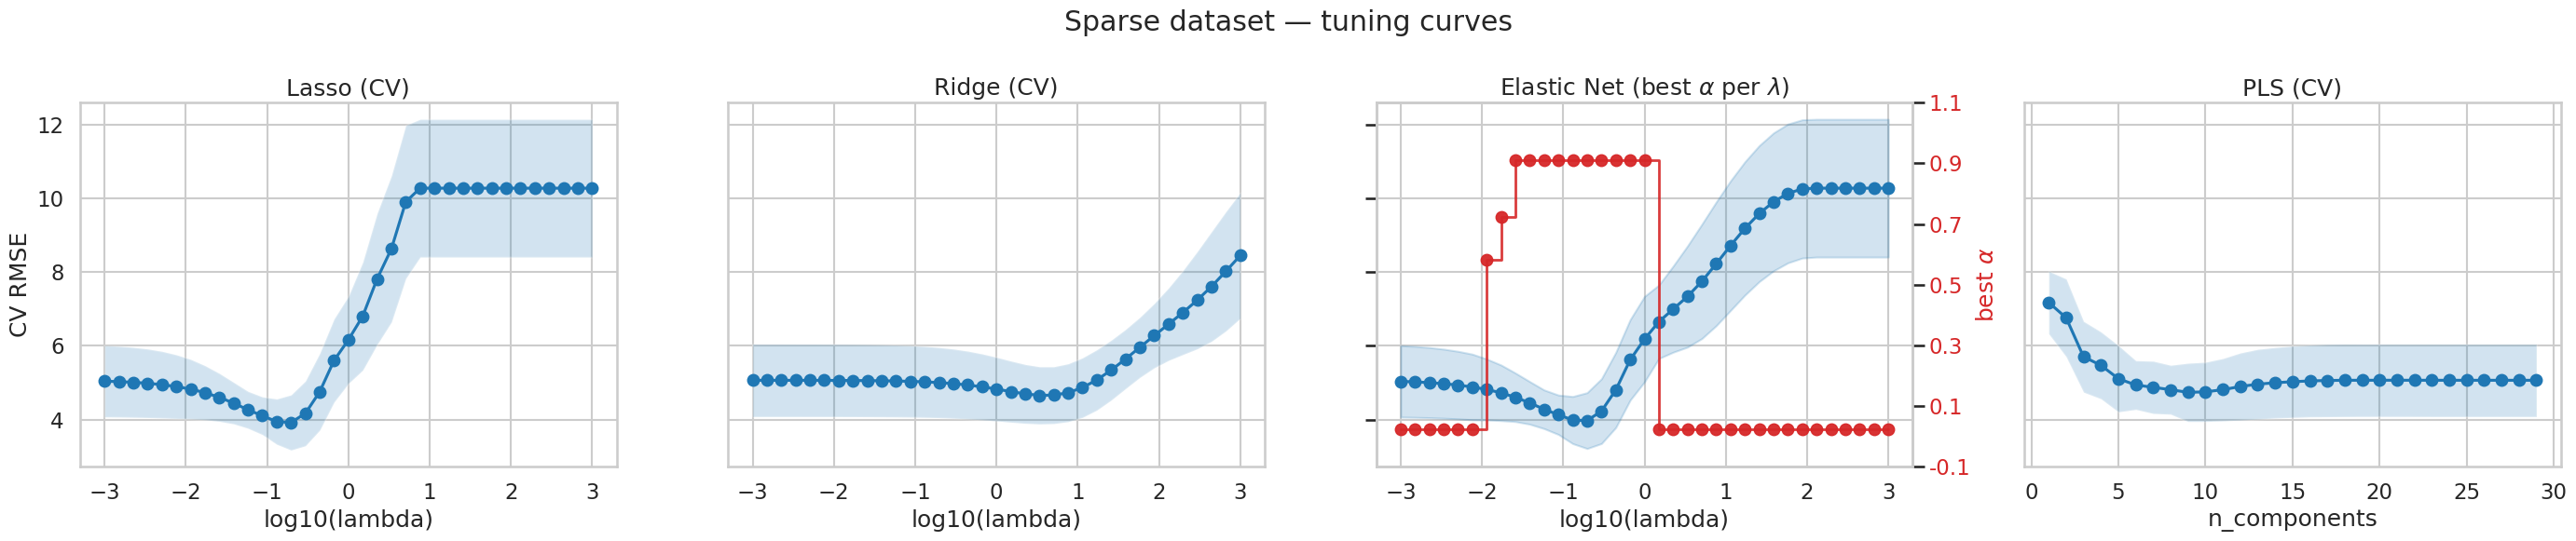

In [ ]:
cv_df = analyse_tuning_curves(
    X_s,
    y_s,
    KFold(n_splits=10, shuffle=True, random_state=42),
    alpha_grid = np.linspace(0.05,0.95,20),
    lambda_grid=np.logspace(-3, 3, 35),
    n_pls_comps=list(range(1, 30)))
plot_tuning_curves(cv_df, title="Sparse dataset — tuning curves")

## Coefficient evolution on a fixed train split
How do coefficients evolve as hyperparameters vary:
- **Lasso** and **Ridge**: paths over  $\lambda$
- **Elastic Net** paths over $\lambda$ with $\alpha = 0.5$
- **PLS**: paths over $n_c$, but transformed back to original features.

In [ ]:
def analyse_coef_evolution_paths(
    X,
    y,
    beta_true,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    lambda_grid=np.logspace(-3, 2, 25),
    alpha_elnet=0.5,
    n_pls_comps=list(range(1, 31))
):
    # Fixed train/test split for visualization
    # outer_cv_viz = KFold(n_splits=3, shuffle=True, random_state=42)
    (train_idx, test_idx) = next(iter(cv.split(X)))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Standardize for path computations (L1/L2)
    scaler_std = StandardScaler()
    X_train_s = scaler_std.fit_transform(X_train)

    # Lasso path (std space, no intercept)
    coefs_lasso = []
    for a in lambda_grid:
        mdl = Lasso(alpha=a, fit_intercept=False, random_state=42)
        mdl.fit(X_train_s, y_train)
        coefs_lasso.append(mdl.coef_)
    coefs_lasso = np.array(coefs_lasso).T

    # Ridge path (std space, no intercept)
    coefs_ridge = []
    for a in lambda_grid:
        mdl = Ridge(alpha=a, fit_intercept=False, random_state=42)
        mdl.fit(X_train_s, y_train)
        coefs_ridge.append(mdl.coef_)
    coefs_ridge = np.array(coefs_ridge).T  # p x n_lambdas

    # Elastic net
    coefs_elnet = []
    for l in lambda_grid:
        mdl = ElasticNet(alpha=l, l1_ratio=alpha_elnet, max_iter=5000, random_state=42)
        mdl.fit(X_train_s, y_train)
        coefs_elnet.append(mdl.coef_)
    coefs_elnet = np.array(coefs_elnet).T  # p x n_lambdas

    # PLS coefficient path over n_components with back-transform to ORIGINAL units
    n_pls_comps = list(range(1, 31))
    coefs_pls = np.zeros((p, len(n_pls_comps)))
    coefs_pls_orig = np.zeros((p, len(n_pls_comps)))
    for t, nc in enumerate(n_pls_comps):
        pipe = Pipeline([("scaler", StandardScaler()), ("model", PLSRegression(n_components=nc, scale=False))])
        pipe.fit(X_train, y_train)
        coef_std = pipe.named_steps["model"].coef_.ravel()  # coef w.r.t standardized features
        sc = pipe.named_steps["scaler"]
        beta_orig = coef_std / sc.scale_  # back-transform to original feature units
        coefs_pls_orig[:, t] = beta_orig
        coefs_pls[:, t] = coef_std

    # Choose a subset of true non-zeros to highlight
    true_idx = np.where(np.abs(beta_true) > 0)[0]
    highlight = true_idx[:min(np.inf, len(true_idx))]

    # Plot paths
    fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
    for j in range(p):
        c = 'tab:blue' if j in highlight else 'lightgray'
        axes[0].plot(lambda_grid, coefs_lasso[j, :], color=c, lw=1)
        axes[1].plot(lambda_grid, np.asarray(coefs_ridge)[j, :], color=c, lw=1)
        axes[2].plot(lambda_grid, np.asarray(coefs_elnet)[j, :], color=c, lw=1)
        axes[3].plot(n_pls_comps, coefs_pls[j, :], color=c, lw=1)

    axes[0].set_xscale('log'); axes[1].set_xscale('log'); axes[2].set_xscale('log')
    # axes[0].invert_xaxis(); axes[1].invert_xaxis()
    axes[0].set_xlabel("$lambda$")
    axes[1].set_xlabel("$lambda$")
    axes[2].set_xlabel("$lambda$")
    axes[3].set_xlabel("n_components")
    axes[0].set_title("Lasso path")
    axes[1].set_title("Ridge path")
    axes[2].set_title(rf"Elastic net path ($\alpha$ = {alpha_elnet})")
    axes[3].set_title("PLS path")
    axes[0].set_ylabel("Coefficient value")
    plt.suptitle("Coefficient evolution across hyperparameters")
    plt.show()

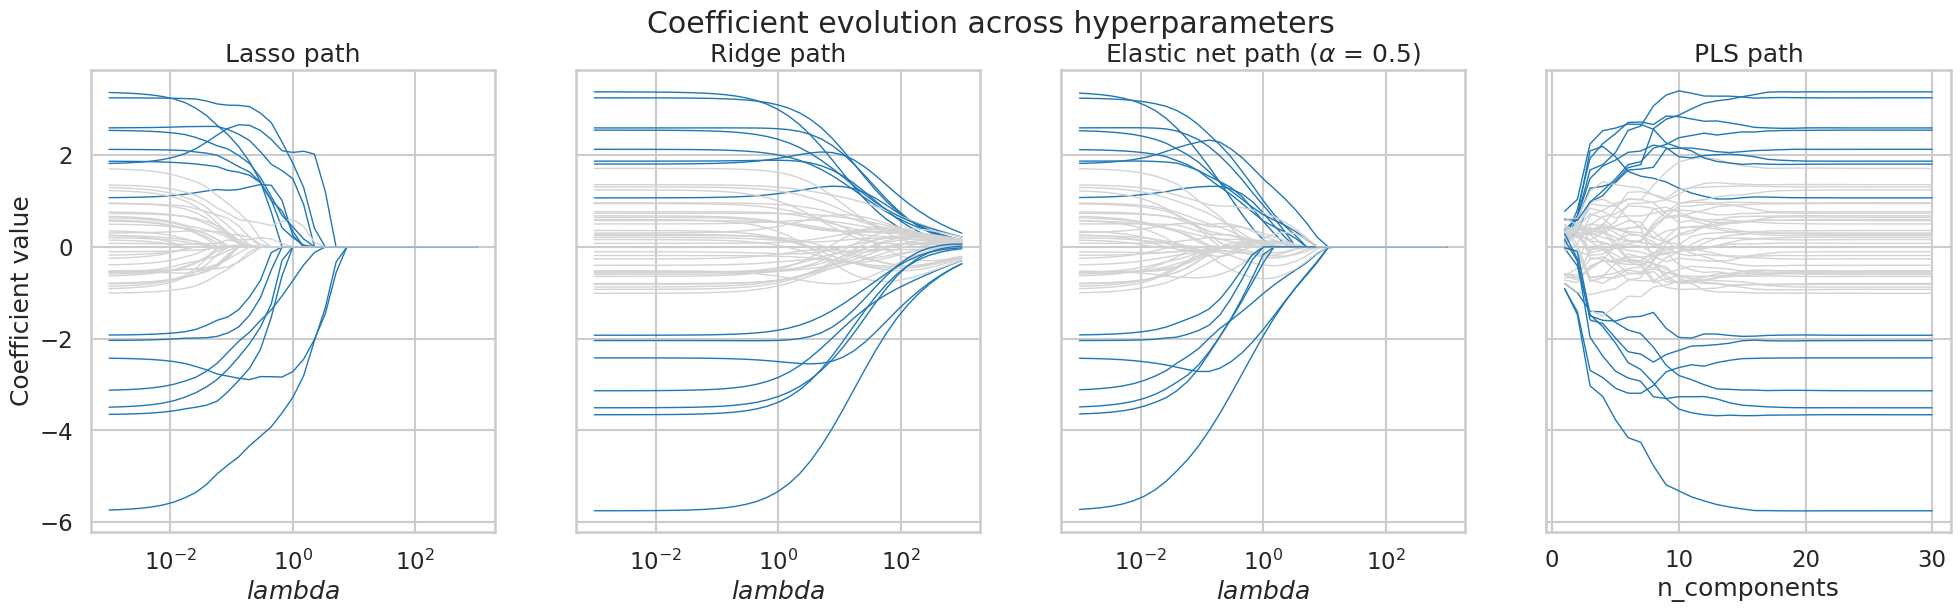

In [ ]:
analyse_coef_evolution_paths(X_s,
    y_s,
    beta_true_s,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    alpha_elnet=0.5,
    lambda_grid=np.logspace(-3, 3, 35),
    n_pls_comps=list(range(1, 30)))

In [ ]:
def unscale_coefs(estimator, ravel=False):
    coef_std = estimator.named_steps["model"].coef_
    if ravel:
        coef_std = coef_std.ravel()  # coefficients w.r.t. standardized X
    scaler = estimator.named_steps["scaler"]

    # Invert scaling to get coefficients in original feature units
    beta = coef_std / scaler.scale_
    intercept = estimator.named_steps["model"].intercept_ - scaler.mean_ @ beta

    return beta, intercept

def compare_coefs_to_ground_thruth(
    X,
    y,
    beta_true,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    lambda_grid=np.logspace(-3, 2, 25),
    alpha_grid = [0.1, 0.3, 0.5, 0.7, 0.9],
    n_pls_comps=list(range(1, 31))
):
    # Fit best-on-train via inner CV and compare coefficients to ground truth

    pipe_lasso = Pipeline([("scaler", StandardScaler()), ("model", Lasso(max_iter=5000, random_state=42))])
    pipe_ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=42))])
    pipe_elnet = Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(max_iter=5000, random_state=42))])
    pipe_pls = Pipeline([("scaler", StandardScaler()), ("model", PLSRegression(scale=False))])

    param_lasso = {"model__alpha": lambda_grid}
    param_ridge = {"model__alpha": lambda_grid}
    param_elnet = {"model__alpha": lambda_grid, "model__l1_ratio":alpha_grid}
    param_pls = {"model__n_components": n_pls_comps}

    cv_lasso = GridSearchCV(pipe_lasso, param_lasso, cv=cv, scoring="neg_root_mean_squared_error")
    cv_ridge = GridSearchCV(pipe_ridge, param_ridge, cv=cv, scoring="neg_root_mean_squared_error")
    cv_elnet = GridSearchCV(pipe_elnet, param_elnet, cv=cv, scoring="neg_root_mean_squared_error")
    cv_pls = GridSearchCV(pipe_pls, param_pls, cv=cv, scoring="neg_root_mean_squared_error")

    cv_lasso.fit(X, y)
    cv_ridge.fit(X, y)
    cv_elnet.fit(X, y)
    cv_pls.fit(X, y)

    best_lasso = cv_lasso.best_estimator_
    best_ridge = cv_ridge.best_estimator_
    best_elnet = cv_elnet.best_estimator_
    best_pls = cv_pls.best_estimator_

    beta_lasso, intercept_lasso = unscale_coefs(best_lasso)
    beta_ridge, intercept_ridge = unscale_coefs(best_ridge)
    beta_elnet, intercept_elnet = unscale_coefs(best_elnet)
    beta_pls, intercept_pls = unscale_coefs(best_pls, ravel=True)

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)
    idx = np.arange(len(beta_lasso))
    axes[0].stem(idx, beta_true, linefmt='k-', markerfmt='ko', basefmt=' ')
    axes[0].stem(idx, beta_lasso, linefmt='tab:orange', markerfmt='o', basefmt=' ')
    axes[0].set_title(rf"Lasso vs True" + "\n" + rf"($\lambda$={cv_lasso.best_params_['model__alpha']:.3g})")
    # axes[0].legend(["True β", "Lasso β̂"], loc='upper right')

    axes[1].stem(idx, beta_true, linefmt='k-', markerfmt='ko', basefmt=' ')
    axes[1].stem(idx, beta_ridge, linefmt='tab:orange', markerfmt='o', basefmt=' ')
    axes[1].set_title(rf"Rigde vs True" + "\n" + rf"($\lambda$={cv_ridge.best_params_['model__alpha']:.3g})")
    # axes[1].legend(["True β", "Ridge β̂"], loc='upper right')

    axes[2].stem(idx, beta_true, linefmt='k-', markerfmt='ko', basefmt=' ')
    axes[2].stem(idx, beta_elnet, linefmt='tab:orange', markerfmt='o', basefmt=' ')
    axes[2].set_title(rf"ElasticNet vs True" + "\n" + rf"($\lambda$={cv_elnet.best_params_['model__alpha']:.3g}, $\alpha$={cv_elnet.best_params_['model__l1_ratio']:.3g})")
    # axes[1].legend(["True β", "Ridge β̂"], loc='upper right')
    axes[3].stem(idx, beta_true, linefmt='k-', markerfmt='ko', basefmt=' ')
    axes[3].stem(idx, beta_pls, linefmt='tab:orange', markerfmt='o', basefmt=' ')
    axes[3].set_title(f"PLS  vs True\n(nc={cv_pls.best_params_['model__n_components']})")
    axes[3].legend(["True β", "estimated β̂"], loc='center left', bbox_to_anchor=(1, 0.5))

    for ax in axes:
        ax.set_xlabel("Feature index")
        ax.set_ylabel("Coefficient")
    # plt.suptitle("Coefficients: recovered vs ground truth")
    plt.show()

## Comparison of coefficients with ground truth

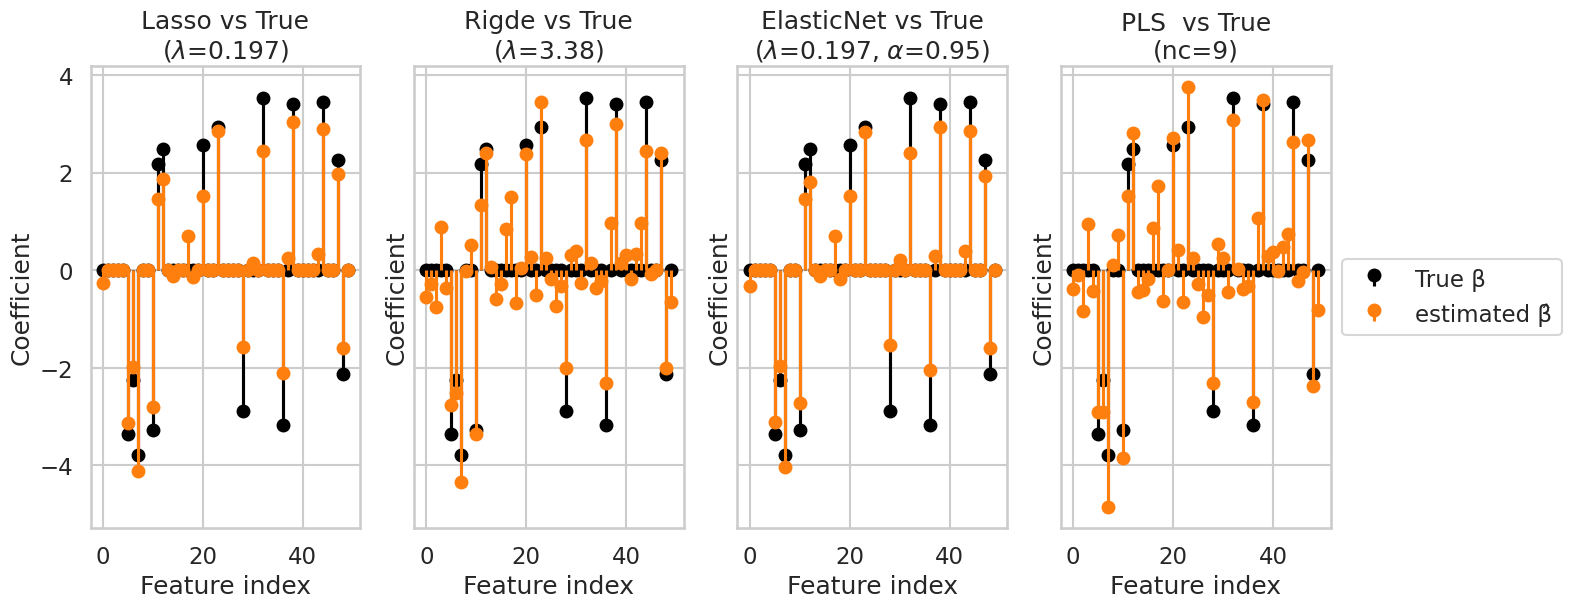

In [ ]:
compare_coefs_to_ground_thruth(
    X_s,
    y_s,
    beta_true_s,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    alpha_grid = np.linspace(0.05,0.95,20),
    lambda_grid=np.logspace(-3, 3, 35),
    n_pls_comps=list(range(1, 30)))

## Nested CV
We now perform **nested 5×5 CV** for general estimates while tuning hyperparameters in the inner loop.

In [ ]:
# Nested CV utilities
from dataclasses import dataclass
from itertools import combinations

@dataclass
class CVResult:
    name: str
    test_rmse: list
    test_r2: list
    supports: list  # list of boolean arrays (support per fold)
    coefs: list     # list of coefficient arrays (per fold)
    best_params: list

def nested_cv_eval(name, base_estimator, param_grid, X, y, inner_folds=10, outer_folds=5,
                   selection_threshold=1e-3, random_state=42):
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)
    inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)

    test_rmse, test_r2 = [], []
    supports, coefs, best_params = [], [], []

    fold_id = 0
    for train_idx, test_idx in outer_cv.split(X):
        fold_id += 1
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("model", base_estimator)
        ])

        if param_grid:
            grid = GridSearchCV(pipe, param_grid=param_grid, cv=inner_cv,
                                scoring="neg_mean_squared_error")
            grid.fit(X_train, y_train)
            best = grid.best_estimator_
            best_params.append(grid.best_params_)
        else:
            best = pipe.fit(X_train, y_train)
            best_params.append({})

        y_pred = best.predict(X_test)
        rmse_val = rmse(y_test, y_pred)
        r2_val = r2_score(y_test, y_pred)
        test_rmse.append(rmse_val)
        test_r2.append(r2_val)

        model = best.named_steps["model"]
        coef = getattr(model, "coef_", None)
        if coef is None:
            coef = np.zeros(X.shape[1])
        if coef.ndim == 2 and coef.shape[1] == 1:
            coef = coef.ravel()
        coefs.append(coef.copy())

        support = np.abs(coef) > selection_threshold
        supports.append(support)

        # After you get grid.best_params_:
        params_str = ", ".join(f"{k.split('__')[-1]}: {v:.3f}" if isinstance(v, (float, np.floating)) else f"{k.split('__')[-1]}: {v}"
                            for k, v in best_params[-1].items())

        print(f"{name}: Outer fold {fold_id}: best params: {{{params_str}}}, RMSE={rmse_val:.3f}, R2={r2_val:.3f}")

    return CVResult(name=name, test_rmse=test_rmse, test_r2=test_r2,
                    supports=supports, coefs=coefs, best_params=best_params)

In [ ]:
# Define models and grids
ols = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(max_iter=5000, random_state=42)
elnet = ElasticNet(max_iter=5000, random_state=42)
pls = PLSRegression(scale=False)  # scaling handled in pipeline

lambda_grid = np.logspace(-3, 3, 35)
alpha_grid = np.linspace(0.05, 0.95, 20)
param_grid_lasso = {"model__alpha": lambda_grid}
param_grid_ridge = {"model__alpha": lambda_grid}
param_grid_elnet = {"model__alpha": lambda_grid, "model__l1_ratio":alpha_grid}
param_grid_pls = {"model__n_components": list(range(1, 16))}
param_grid_ols = {}

# res_ols = nested_cv_eval("OLS", ols, param_grid_ols, X_s, y_s)
# res_lasso = nested_cv_eval("Lasso", lasso, param_grid_lasso, X_s, y_s)
# res_ridge = nested_cv_eval("Ridge", ridge, param_grid_ridge, X_s, y_s)
# res_elnet = nested_cv_eval("ElasticNet", elnet, param_grid_elnet, X_s, y_s)
# res_pls = nested_cv_eval("PLS", pls, param_grid_pls, X_s, y_s)

In [ ]:
def summarize(res):
    rrmse = np.array(res.test_rmse)
    rr2 = np.array(res.test_r2)
    k = np.array([s.sum() for s in res.supports])


    return {
        "Model": res.name,
        "RMSE (mean±sd)": f"{rrmse.mean():.3f} ± {rrmse.std():.3f}",
        "R2 (mean±sd)": f"{rr2.mean():.3f} ± {rr2.std():.3f}",
        "Selected k (mean±sd)": f"{k.mean():.1f} ± {k.std():.1f}",
    }

# summary_df = pd.DataFrame([summarize(res_ols), summarize(res_lasso), summarize(res_ridge), summarize(res_elnet), summarize(res_pls)])
# summary_df

## Example 2: Dens dataset
- Same features
- All features are active
- All $\beta$ for each block are equal

$$
 y = X\,\beta + \epsilon,\quad \epsilon\sim\mathcal N\!\left(0,\,\sigma^2 \right)
$$

In [ ]:
# simulate once
X_d, y_d, beta_true_d = simulate_regression_dense_grouped(n=n, p=p, block_size=block_size, rho=rho, snr=2.5, tau=1.0, rng=321)
print("X shape:", X_d.shape, " y shape:", y_d.shape)
print("Nonzero in true beta:", np.count_nonzero(beta_true_d))

X shape: (100, 50)  y shape: (100,)
Nonzero in true beta: 50


<Axes: >

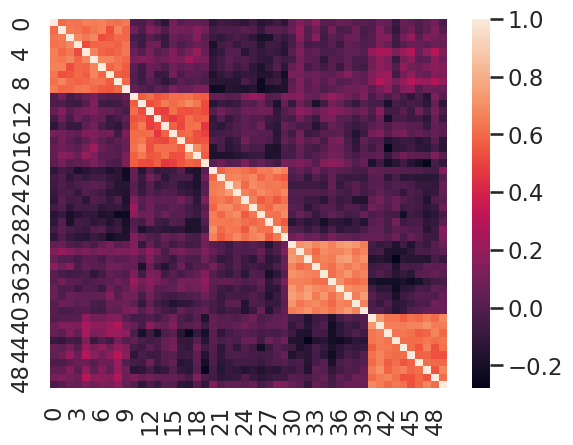

In [ ]:
sns.heatmap(pd.DataFrame(data=X_d).corr())

## CV analysis: tuning curves & RMSE distributions

        model      value  mean_rmse   sd_rmse
0  ElasticNet   0.131113   1.130494  0.245204
1       Lasso   0.087333   1.130875  0.274498
2         PLS   2.000000   1.021168  0.190274
3       Ridge  58.170913   1.052429  0.194357


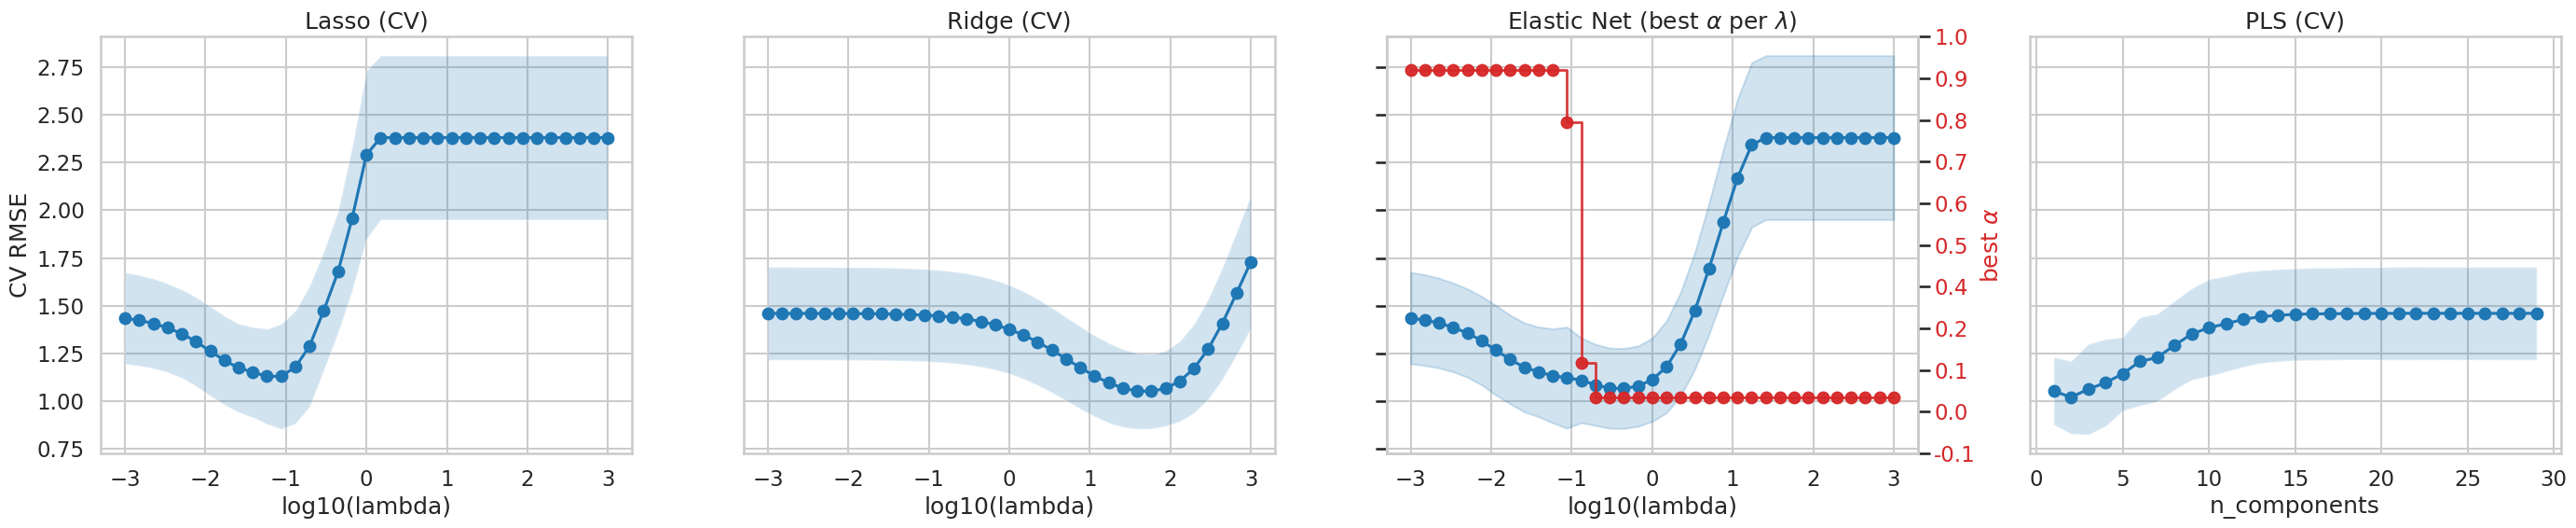

In [ ]:
cv_df = analyse_tuning_curves(
    X_d,
    y_d,
    KFold(n_splits=10, shuffle=True, random_state=42),
    alpha_grid = np.linspace(0.05,0.95,20),
    lambda_grid=np.logspace(-3, 3, 35),
    n_pls_comps=list(range(1, 30)))
plot_tuning_curves(cv_df)

## Coefficient evolution on a fixed train split

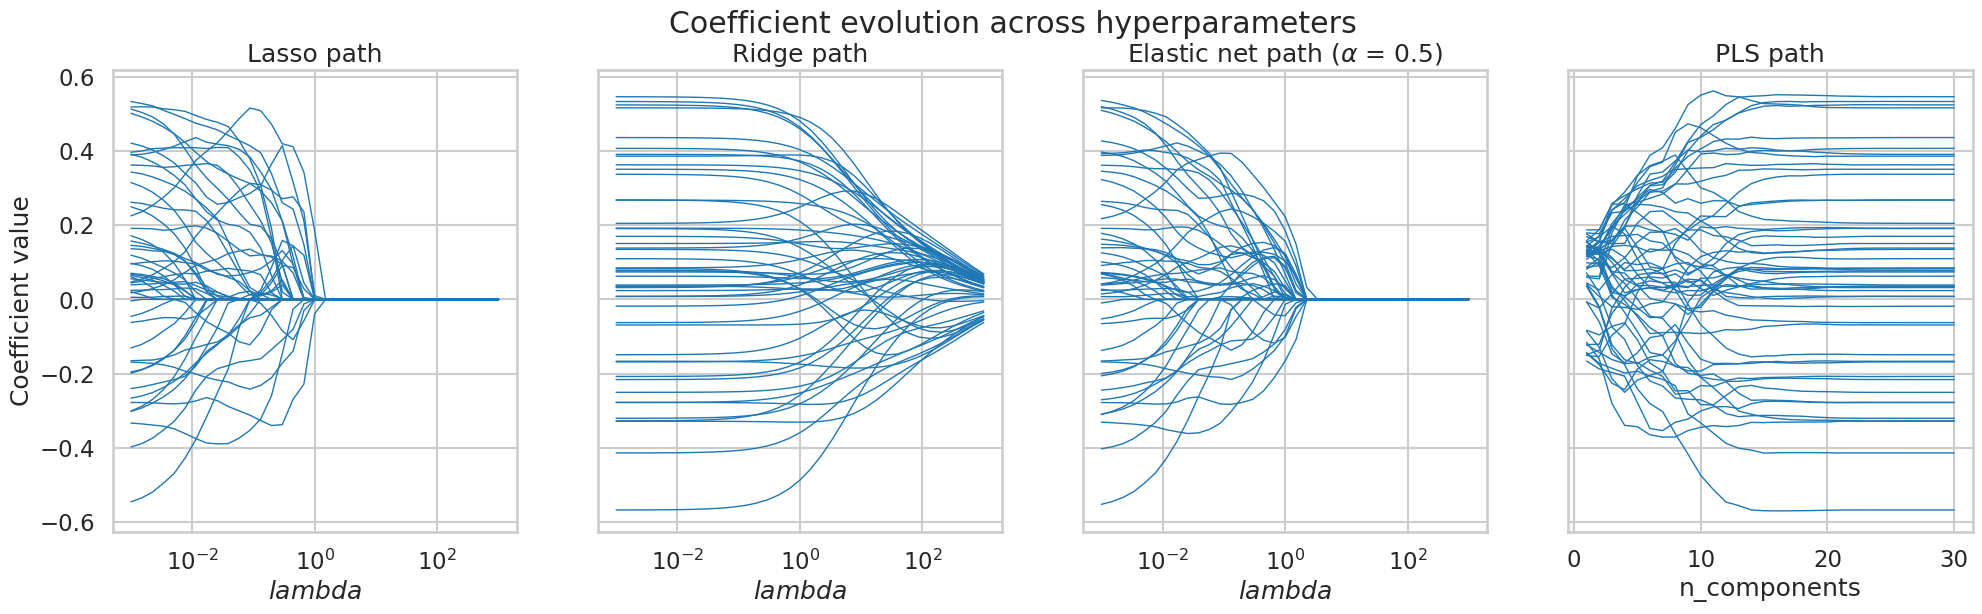

In [ ]:
analyse_coef_evolution_paths(
    X_d,
    y_d,
    beta_true_d,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    alpha_elnet=0.5,
    lambda_grid=np.logspace(-3, 3, 35),
    n_pls_comps=list(range(1, 30)))

## Comparison to ground truth

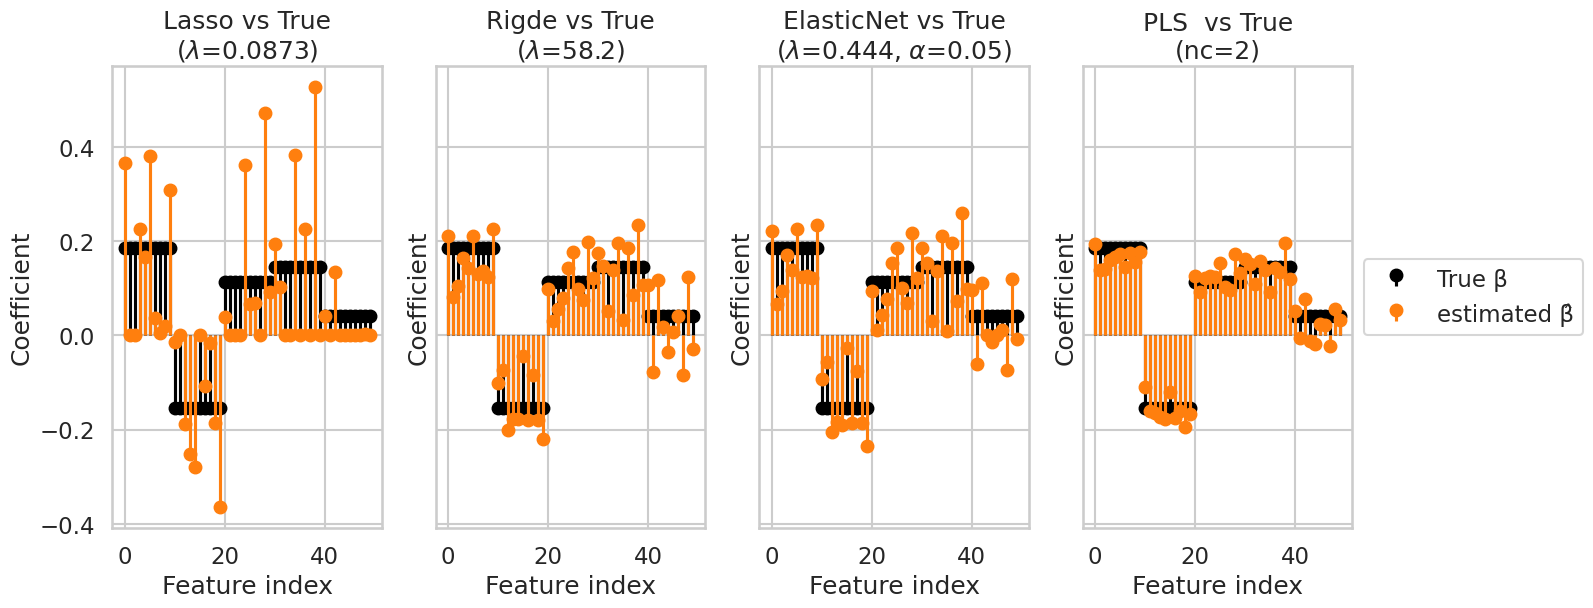

In [ ]:
compare_coefs_to_ground_thruth(
    X_d,
    y_d,
    beta_true_d,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    alpha_grid = np.linspace(0.05,0.95,20),
    lambda_grid=np.logspace(-3, 3, 35),
    n_pls_comps=list(range(1, 30)))

In [ ]:
# res_ols = nested_cv_eval("OLS", ols, param_grid_ols, X_d, y_d)
# res_lasso = nested_cv_eval("Lasso", lasso, param_grid_lasso, X_d, y_d)
# res_ridge = nested_cv_eval("Ridge", ridge, param_grid_ridge, X_d, y_d)
# res_elnet = nested_cv_eval("ElasticNet", elnet, param_grid_elnet, X_d, y_d)
# res_pls = nested_cv_eval("PLS", pls, param_grid_pls, X_d, y_d)

Using Diabetes dataset

In [ ]:
# # ================================================================
# # Diabetes — L1 vs L2 vs PLS
# # Figures:
# # 1) Inner-CV tuning curves (mean±sd)
# # 2) Coefficient evolution across hyperparameters (std space)
# # 3) Coefficients: recovered vs ground truth (OLS reference)
# # Formatting matches your screenshots.
# # ================================================================

# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.datasets import load_diabetes
# from sklearn.model_selection import KFold, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LinearRegression, Lasso, Ridge
# from sklearn.cross_decomposition import PLSRegression

# # ---------- helpers ----------
# def rmse_from_neg(value):
#     # GridSearchCV with scoring="neg_root_mean_squared_error" returns negative RMSE
#     return -value

# def unscale_coefs(estimator, ravel=False):
#     """Transform pipeline coefficients back to original X-units."""
#     coef_std = estimator.named_steps["model"].coef_
#     if ravel:
#         coef_std = coef_std.ravel()
#     scaler = estimator.named_steps["scaler"]
#     beta = coef_std / scaler.scale_
#     intercept = estimator.named_steps["model"].intercept_ - scaler.mean_ @ beta
#     return beta, intercept

# # ---------- data ----------
# data = load_diabetes()
# X, y = data.data, data.target
# p = X.shape[1]
# feature_names = list(getattr(data, "feature_names", [f"x{i}" for i in range(p)]))

# # ---------- pipelines ----------
# pipe_ref   = Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())])                 # reference
# pipe_lasso = Pipeline([("scaler", StandardScaler()), ("model", Lasso(max_iter=5000, random_state=42))])
# pipe_ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=42))])
# pipe_pls   = Pipeline([("scaler", StandardScaler()), ("model", PLSRegression(scale=False))])

# # ---------- grids & CV ----------
# alpha_grid = np.logspace(-3, 2, 25)          # for L1/L2
# pls_grid   = list(range(1, min(30, p) + 1))  # up to 30 or p, whichever is smaller
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# gs_lasso = GridSearchCV(pipe_lasso, {"model__alpha": alpha_grid}, cv=cv,
#                         scoring="neg_root_mean_squared_error", return_train_score=False)
# gs_ridge = GridSearchCV(pipe_ridge, {"model__alpha": alpha_grid}, cv=cv,
#                         scoring="neg_root_mean_squared_error", return_train_score=False)
# gs_pls   = GridSearchCV(pipe_pls,   {"model__n_components": pls_grid}, cv=cv,
#                         scoring="neg_root_mean_squared_error", return_train_score=False)

# # ---------- fit searches ----------
# gs_lasso.fit(X, y)
# gs_ridge.fit(X, y)
# gs_pls.fit(X, y)

# # ================================================================
# # 1) Inner-CV tuning curves (mean±sd)
# # ================================================================
# fig, axes = plt.subplots(1, 3, figsize=(16, 5))
# plt.suptitle("Inner-CV tuning curves (mean±sd)")

# # Lasso
# mask = np.argsort(gs_lasso.cv_results_["param_model__alpha"].data.astype(float))
# a = np.array(gs_lasso.cv_results_["param_model__alpha"].data.astype(float))[mask]
# m = np.array(gs_lasso.cv_results_["mean_test_score"])[mask]
# s = np.array(gs_lasso.cv_results_["std_test_score"])[mask]
# axes[0].fill_between(np.log10(a), rmse_from_neg(m - s), rmse_from_neg(m + s), alpha=0.2)
# axes[0].plot(np.log10(a), rmse_from_neg(m), 'o-')
# axes[0].set_title("Lasso RMSE_CV")
# axes[0].set_xlabel("log10(alpha)")
# axes[0].set_ylabel("RMSE")

# # Ridge
# mask = np.argsort(gs_ridge.cv_results_["param_model__alpha"].data.astype(float))
# a = np.array(gs_ridge.cv_results_["param_model__alpha"].data.astype(float))[mask]
# m = np.array(gs_ridge.cv_results_["mean_test_score"])[mask]
# s = np.array(gs_ridge.cv_results_["std_test_score"])[mask]
# axes[1].fill_between(np.log10(a), rmse_from_neg(m - s), rmse_from_neg(m + s), alpha=0.2)
# axes[1].plot(np.log10(a), rmse_from_neg(m), 'o-')
# axes[1].set_title("Ridge RMSE_CV")
# axes[1].set_xlabel("log10(alpha)")

# # PLS
# mask = np.argsort(gs_pls.cv_results_["param_model__n_components"].data.astype(int))
# k = np.array(gs_pls.cv_results_["param_model__n_components"].data.astype(int))[mask]
# m = np.array(gs_pls.cv_results_["mean_test_score"])[mask]
# s = np.array(gs_pls.cv_results_["std_test_score"])[mask]
# axes[2].fill_between(k, rmse_from_neg(m - s), rmse_from_neg(m + s), alpha=0.2)
# axes[2].plot(k, rmse_from_neg(m), 'o-')
# axes[2].set_title("PLS RMSE_CV")
# axes[2].set_xlabel("n_components")

# plt.tight_layout()
# plt.show()

# # ================================================================
# # 2) Coefficient evolution across hyperparameters (std space)
# #    We refit on STANDARDIZED X to show paths in "std space".
# # ================================================================
# Xs = StandardScaler().fit_transform(X)  # std space for paths

# # Lasso path (std space)
# coef_lasso_path = []
# for a in alpha_grid:
#     m = Lasso(alpha=a, max_iter=5000, random_state=42).fit(Xs, y)
#     coef_lasso_path.append(m.coef_)
# coef_lasso_path = np.array(coef_lasso_path)  # shape: len(alpha_grid) x p

# # Ridge path (std space)
# coef_ridge_path = []
# for a in alpha_grid:
#     m = Ridge(alpha=a, random_state=42).fit(Xs, y)
#     coef_ridge_path.append(m.coef_)
# coef_ridge_path = np.array(coef_ridge_path)

# # PLS path (std space): coefficients of standardized features vs n_components
# coef_pls_path = []
# for k in pls_grid:
#     m = PLSRegression(n_components=k, scale=False).fit(Xs, y)
#     # PLSRegression.coef_ has shape (p, 1)
#     coef_pls_path.append(m.coef_.ravel())
# coef_pls_path = np.array(coef_pls_path)

# fig, axes = plt.subplots(1, 3, figsize=(16, 5))
# plt.suptitle("Coefficient evolution across hyperparameters (highlight: true non-zeros)")

# for j in range(p):
#     axes[0].semilogx(alpha_grid, coef_lasso_path[:, j])
# axes[0].set_title("Lasso path (std space)")
# axes[0].set_xlabel("alpha"); axes[0].set_ylabel("Coefficient value")

# for j in range(p):
#     axes[1].semilogx(alpha_grid, coef_ridge_path[:, j])
# axes[1].set_title("Ridge path (std space)")
# axes[1].set_xlabel("alpha")

# for j in range(p):
#     axes[2].plot(pls_grid, coef_pls_path[:, j])
# axes[2].set_title("PLS path (std space)")
# axes[2].set_xlabel("n_components")

# plt.tight_layout()
# plt.show()

# # ================================================================
# # 3) Coefficients: recovered vs ground truth (OLS reference)
# #    Unscale all models to original X-units and stem-plot vs reference.
# # ================================================================
# ref = pipe_ref.fit(X, y)
# beta_ref, _ = unscale_coefs(ref)  # "ground truth" reference (OLS)

# best_lasso = gs_lasso.best_estimator_
# best_ridge = gs_ridge.best_estimator_
# best_pls   = gs_pls.best_estimator_

# beta_lasso, _ = unscale_coefs(best_lasso)
# beta_ridge, _ = unscale_coefs(best_ridge)
# beta_pls,   _ = unscale_coefs(best_pls, ravel=True)

# fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
# plt.suptitle("Coefficients: recovered vs ground truth")
# idx = np.arange(p)

# # Lasso vs True
# axes[0].stem(idx, beta_ref,   linefmt='k-',          markerfmt='ko', basefmt=' ')
# axes[0].stem(idx, beta_lasso, linefmt='tab:orange',  markerfmt='o',  basefmt=' ')
# axes[0].set_title(f"Lasso vs True (alpha={best_lasso.get_params()['model__alpha']:.3g})")
# axes[0].set_xlabel("Feature index"); axes[0].set_ylabel("Coefficient")

# # Ridge vs True
# axes[1].stem(idx, beta_ref,   linefmt='k-',          markerfmt='ko', basefmt=' ')
# axes[1].stem(idx, beta_ridge, linefmt='tab:orange',  markerfmt='o',  basefmt=' ')
# axes[1].set_title(f"Ridge vs True (alpha={best_ridge.get_params()['model__alpha']:.3g})")
# axes[1].set_xlabel("Feature index")

# # PLS vs True
# axes[2].stem(idx, beta_ref,   linefmt='k-',          markerfmt='ko', basefmt=' ')
# axes[2].stem(idx, beta_pls,   linefmt='tab:orange',  markerfmt='o',  basefmt=' ')
# axes[2].set_title(f"PLS  vs True (n_components={best_pls.get_params()['model__n_components']})")
# axes[2].set_xlabel("Feature index")
# axes[2].legend(["True β", "estimated β"], loc='center left', bbox_to_anchor=(1, 0.5))

# plt.tight_layout()
# plt.show()


## Strict feature selection with stepwise L1 and L2 regression

From the Paper:
Demir-Kavuk, Ozgur & Kamada, Mayumi & Akutsu, Tatsuya & Knapp, Ernst-Walter. (2011). Prediction using step-wise L1, L2 regularization and feature selection for small data sets with large number of features. BMC bioinformatics. 12. 412. 10.1186/1471-2105-12-412.

In [ ]:
class LassoRegression:
    def __init__(self, alpha=1.0, max_iter=1000, tol=1e-4):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None

    def soft_threshold(self, x, lambda_):
        return np.sign(x) * np.maximum(np.abs(x) - lambda_, 0)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        for _ in range(self.max_iter):
            weights_old = self.weights.copy()

            for j in range(n_features):
                r = y - np.dot(X, self.weights) + self.weights[j] * X[:, j]
                self.weights[j] = self.soft_threshold(
                    np.dot(X[:, j], r),
                    self.alpha * n_samples
                ) / (np.dot(X[:, j], X[:, j]))

            if np.sum(np.abs(self.weights - weights_old)) < self.tol:
                break
X_old, y_old, beta_true_old = simulate_regression_sparse(n=n, p=p, block_size=block_size, rho=rho, snr=snr, rng=123, nonzero_per_block=3)

### Selecting features with Increasing $\lambda$ value

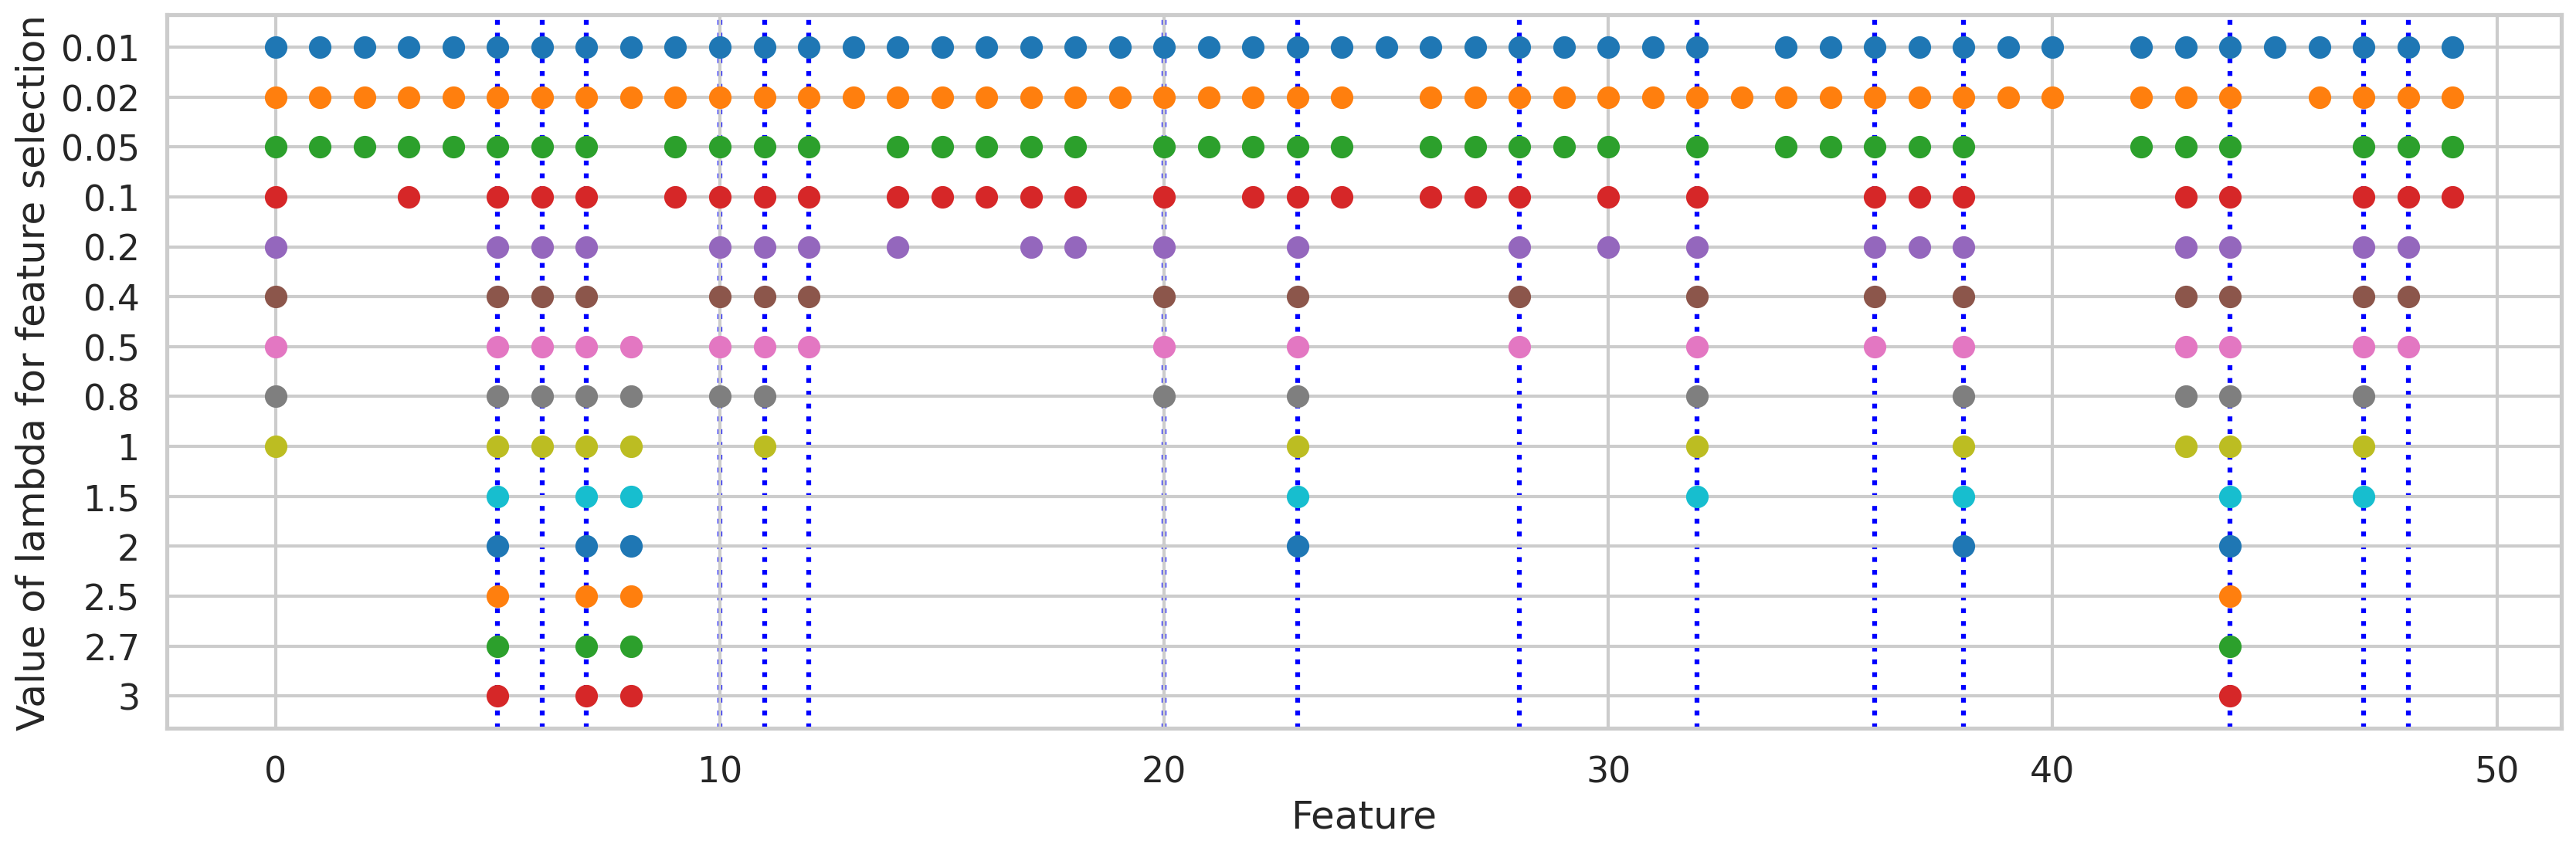

In [ ]:
array = [0.01, 0.02, 0.05, 0.1,0.2,0.4,0.5,0.8,1,1.5,2,2.5,2.7,3]

def l1_feature_reduction(alpha_values=array, r = False):


    ks = np.arange(len(alpha_values))
    truths = np.arange(len(beta_true_old))[beta_true_old!= 0]
    weights = []

    for a in alpha_values:
        mod = LassoRegression(alpha= a)
        mod.fit(X_old,y_old)
        w = mod.weights
        weights.append(w)
        n_features = np.count_nonzero(w)

    weights = np.array(weights)!= 0

    a = np.tile(np.arange(len(weights[0])), (weights.shape[0],1))
    #print(a.shape)
    idxs = a[weights]

    prev = 0

    if not r:
        plt.figure(figsize=(20, 6), dpi=200)

        for i in truths:
            plt.axvline(x = i, color = 'b',zorder = 0, linestyle = ":")

        for i,row in enumerate(weights):
            n_features = np.count_nonzero(row)
            plt.scatter(idxs[prev:prev+n_features], [ks[i]]*n_features)
            prev+=n_features
        plt.gca().invert_yaxis()
        ylables = [str(k) for k in alpha_values]
        plt.yticks(ticks=ks, labels=ylables)
        plt.xlabel("Feature")
        plt.ylabel("Value of lambda for feature selection")
        plt.show()
    else:
        return np.ceil(np.abs(weights)/np.max(weights))



l1_feature_reduction(array)

### Preform L2 regression to tune the weights

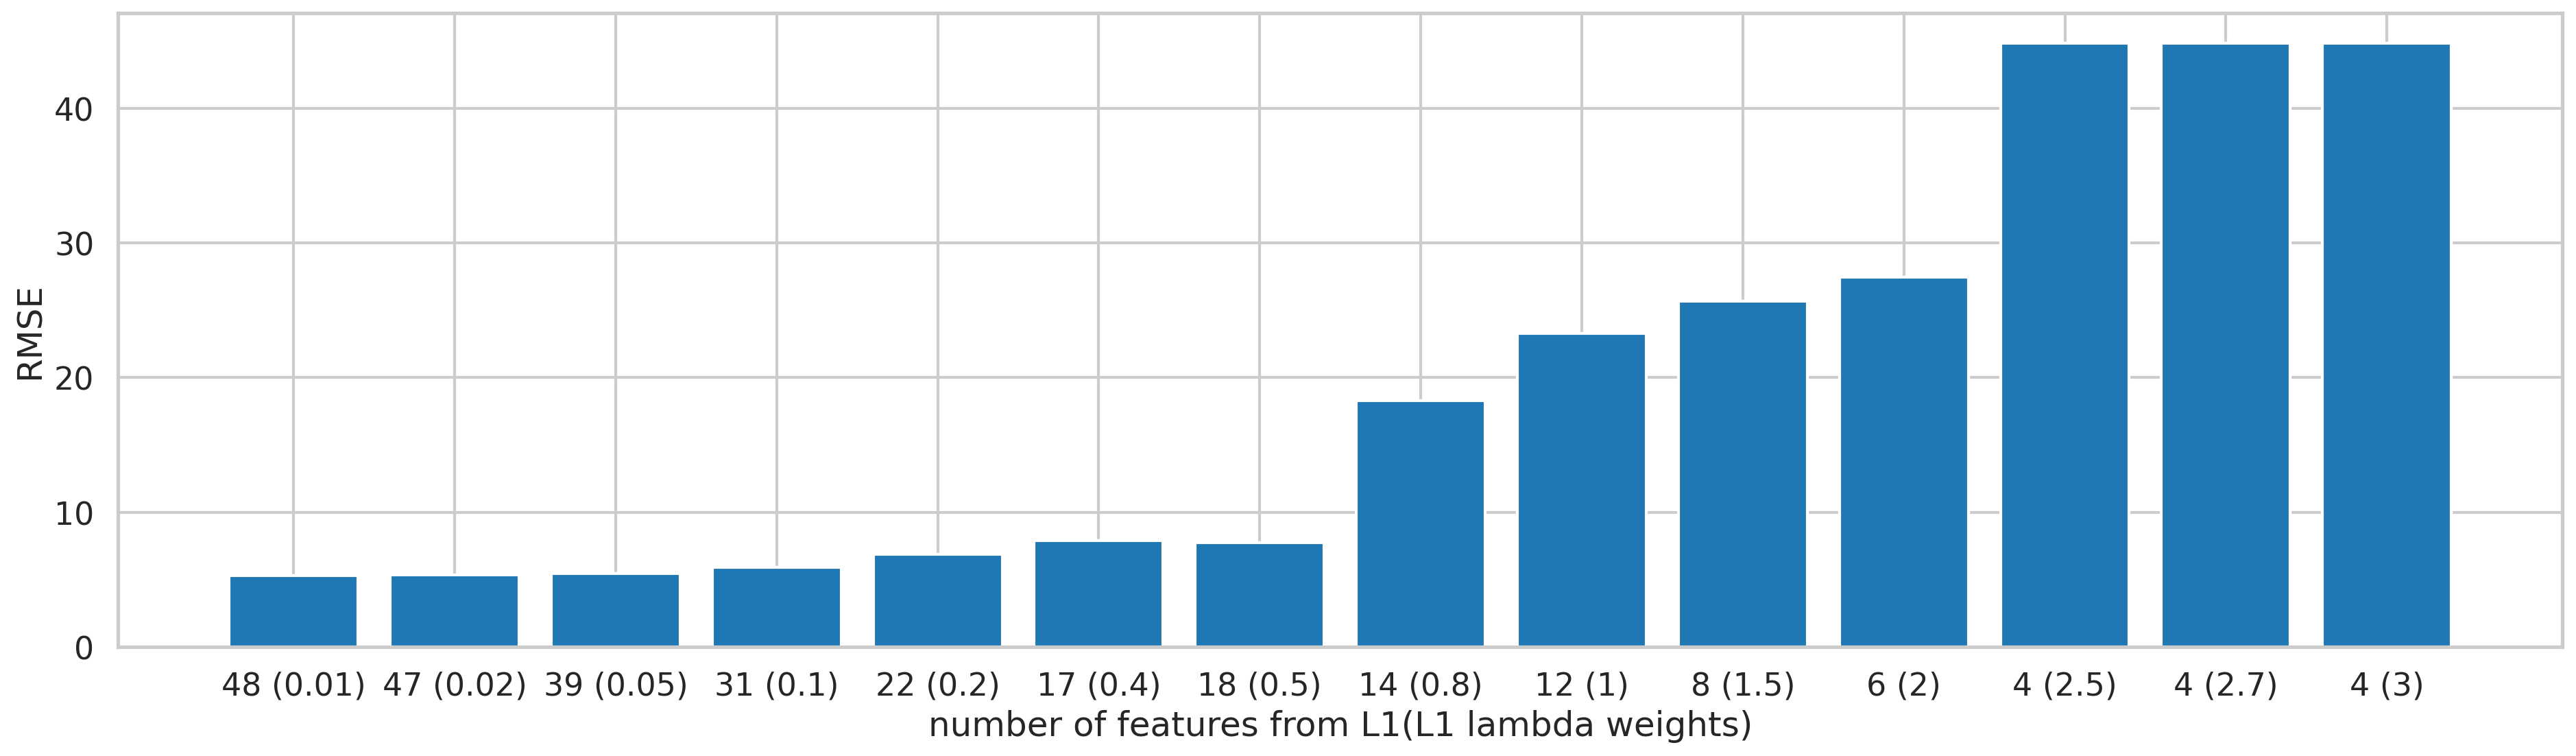

In [ ]:
#Selecting

selected_weights =[0.01, 0.02, 0.05, 0.1,0.2,0.4,0.5,0.8,1,1.5,2,2.5,2.7,3]
alpha_grid=np.logspace(-3, 2, 25)
features = l1_feature_reduction(selected_weights, r = True)

feature_n = [np.sum(f) for f in features]
#print(features)
RMSE = []
plt.figure(figsize=(23, 6), dpi=200)
for f in features:
    x_new = X_old[:,f.astype(bool)]
    #print(x_new.shape)
    rmse_min = 999999999
    alpha = 0
    for a in alpha_grid:
        mod = Ridge(fit_intercept=True, alpha=a)
        mod.fit(x_new,y_old)
        y_pred = mod.predict(x_new)
        rmse = np.mean((y_old-y_pred)**2)

        if rmse < rmse_min:
            rmse_min = rmse
            alpha = a
    #print(rmse)
    RMSE.append(rmse_min)





plt.bar(np.arange(len(RMSE)), RMSE)
plt.xticks(ticks=np.arange(len(RMSE)), labels=[f'{str(int(f))} ({str(l1)})' for f,l1 in zip(feature_n, selected_weights)])
plt.xlabel("number of features from L1(L1 lambda weights)")
plt.ylabel("RMSE")
plt.show()

#### All alphas are 0.001!

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.730e+02, tolerance: 1.040e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.933e+02, tolerance: 1.040e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

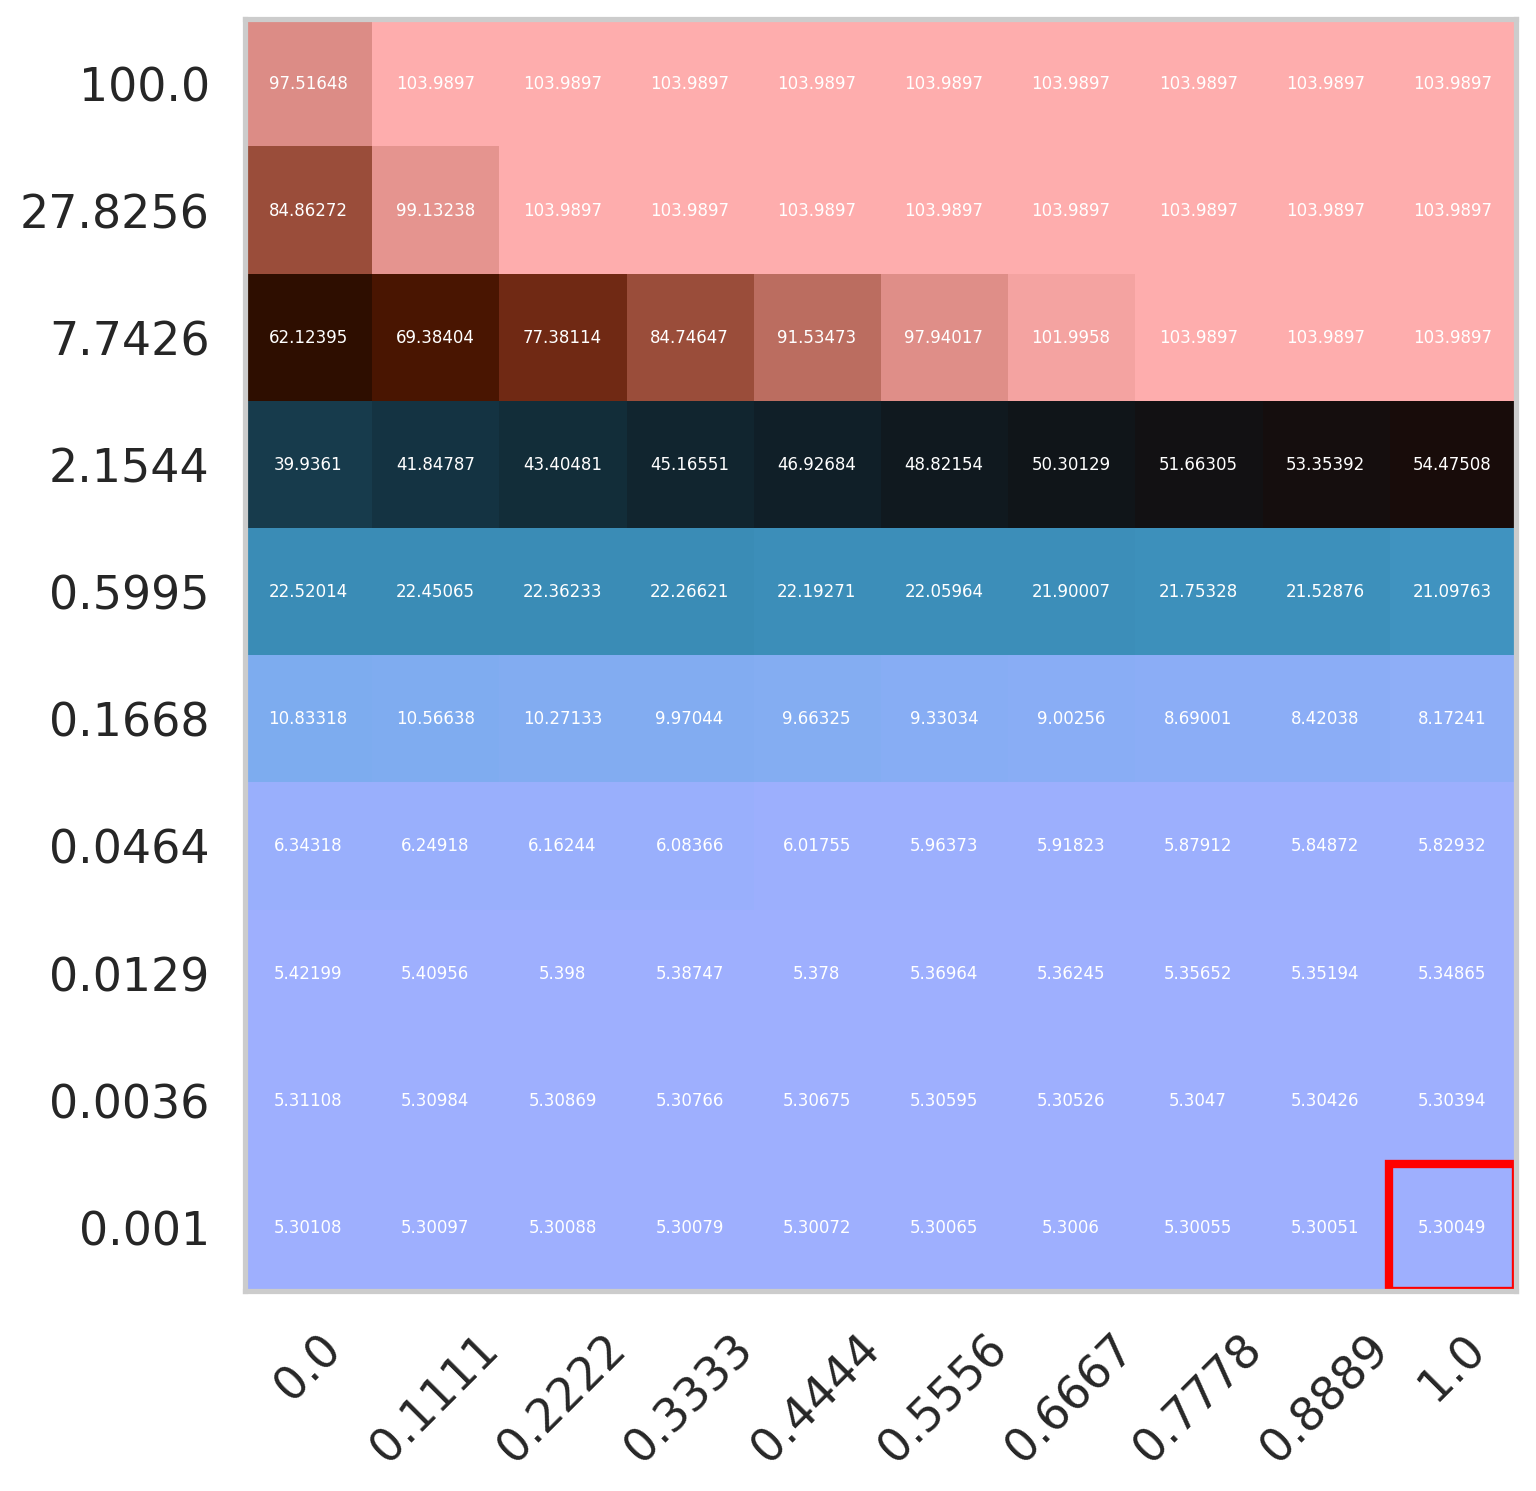

In [ ]:
lambda_grid  = np.logspace(-3, 2, 10)
alpha = np.linspace(0,1,10)
from matplotlib.patches import Rectangle

alpha_res = []
lambda_res = []
rmse_gruid = []
tst  = np.random.random((10,10))
for l in lambda_grid:
    rmse_temp = []
    for a in alpha:
        mod = ElasticNet(alpha=l, l1_ratio=  a)
        mod.fit(X_old, y_old)
        y_pred = mod.predict(X_old)
        rmse = np.mean((y_old-y_pred)**2)
        rmse_temp.append(rmse)
    rmse_gruid.append(rmse_temp)

fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
ax.imshow(rmse_gruid, cmap="berlin")
ax.set_xticks(range(len(alpha)), labels=[str(round(k,4)) for k in alpha],rotation=45)
ax.set_yticks(range(len(alpha)), labels=[str(round(k,4)) for k in lambda_grid])
ax.invert_yaxis()
fig.tight_layout()
m = np.min(rmse_gruid)
for i in range(10):
    for j in range(10):
        txt = ax.text(j,i, round(rmse_gruid[i][j],5), ha = "center", va = "center", color = "w", fontsize = 6)
        if rmse_gruid[i][j] == m:
            ax.add_patch(Rectangle((j-0.5,i-0.5), 1,1, fill = False, edgecolor='red', lw = 3))
ax.grid(False)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pysindy as ps
import pandas as pd

ModuleNotFoundError: No module named 'pysindy'

## L1 Regularization in SINDy

### Sparse Identification of Nonlinear Dynamics (SINDy)

<p style="text-align: center;"><em>"SINDy discovers a simple set of governing equations for a system by fitting a library of candidate functions and keeping only the necessary terms."</em></p>

#### Example

<img src="lorentz.png" style="display: block; margin: 0 auto; width:65%;">

#### Sparse Regression

$$\arg\min_{\mathbf{\Xi}}\|\dot{\mathbf{X}}-\mathbf{\Theta}(\mathbf{X})\mathbf{\Xi}\|_2^2+\colorbox{lime}{$\lambda\|\mathbf{\Xi}\|_1$}$$

In [ ]:
# Lorenz system
def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Integration function
def simulate_lorenz(initial_state, sigma, rho, beta, t_span, dt):
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(
        lorenz, t_span, initial_state, t_eval=t_eval, args=(sigma, rho, beta)
    )
    return sol.y.T, sol.t

# Parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
dt = 0.01
t_span = (0, 25)

In [ ]:
# Initial condition
x0 = [1.0, 1.0, 1.0]

# 1. Reference trajectory
traj_ref, t = simulate_lorenz(x0, sigma, rho, beta, t_span, dt)

# 2. Slightly different initial condition, same parameters
x0_perturbed = [2, 2, 2]
traj_init, _ = simulate_lorenz(x0_perturbed, sigma, rho, beta, t_span, dt)

# 3. Same initial condition, but perturbed parameters
sigma_p, rho_p, beta_p = sigma * 1.3, rho * 1.3, beta * 1.3
traj_param, _ = simulate_lorenz(x0, sigma_p, rho_p, beta_p, t_span, dt)

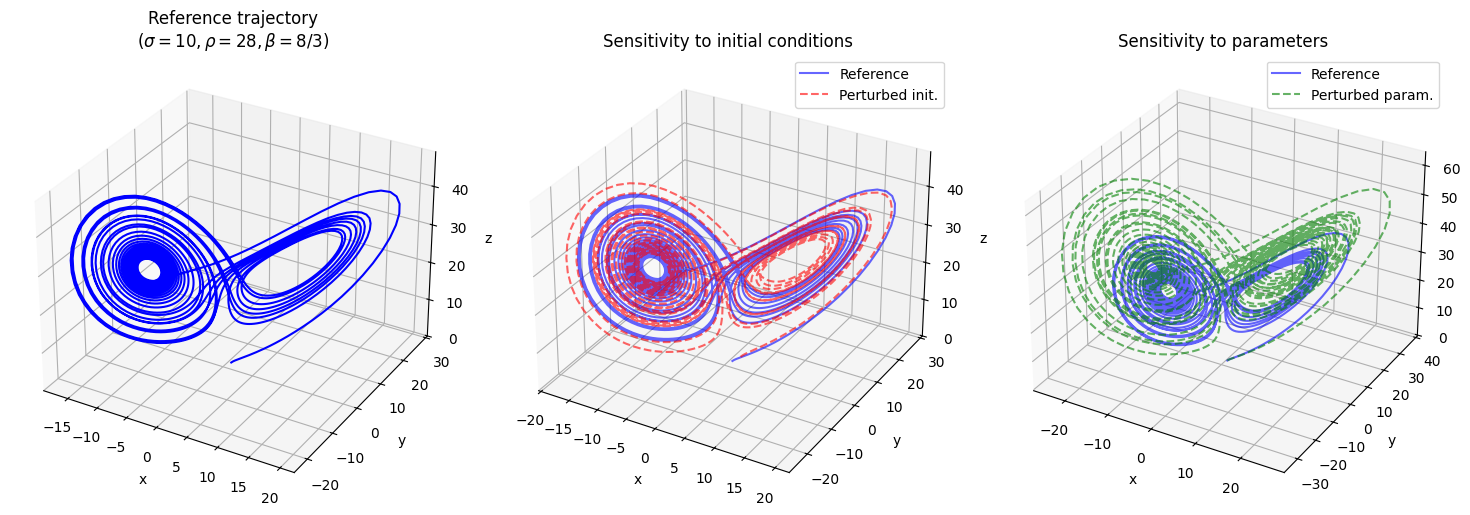

In [ ]:
# Plot
fig = plt.figure(figsize=(15, 5))

# Left: Reference trajectory
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(traj_ref[:, 0], traj_ref[:, 1], traj_ref[:, 2], color="blue")
ax1.set_title("Reference trajectory\n($\\sigma=10, \\rho=28, \\beta=8/3$)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

# Middle: Sensitivity to initial conditions
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot(traj_ref[:, 0], traj_ref[:, 1], traj_ref[:, 2], color="blue", alpha=0.6, label="Reference")
ax2.plot(traj_init[:, 0], traj_init[:, 1], traj_init[:, 2], color="red", alpha=0.6, label="Perturbed init.", linestyle="dashed")
ax2.set_title("Sensitivity to initial conditions")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.legend()

# Right: Sensitivity to parameters
ax3 = fig.add_subplot(133, projection="3d")
ax3.plot(traj_ref[:, 0], traj_ref[:, 1], traj_ref[:, 2], color="blue", alpha=0.6, label="Reference")
ax3.plot(traj_param[:, 0], traj_param[:, 1], traj_param[:, 2], color="green", alpha=0.6, label="Perturbed param.", linestyle="dashed")
ax3.set_title("Sensitivity to parameters")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
ax3.legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- Fit SINDy ---
lib = ps.PolynomialLibrary()
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib,
    optimizer=opt
)
model.fit(traj_ref, t=dt, feature_names=["x","y","z"])

# extract estimated params
xi = model.coefficients()
est_sigma = -xi[0][1]
est_rho   = xi[1][1]
est_beta  = -xi[2][3]

# Reconstruct trajectory
# traj_sindy = model.simulate(x0, t)
traj_sindy, t = simulate_lorenz(x0, est_sigma, est_rho, est_beta, t_span, dt)

NameError: name 'ps' is not defined

In [ ]:
# --- Plot actual vs reconstructed ---
fig, axes = plt.subplots(1, 1, figsize=(12,5), subplot_kw={'projection':'3d'})

# Left: true trajectory
axes.plot(traj_ref[:,0], traj_ref[:,1], traj_ref[:,2], color="blue", label="True trajectory")
axes.plot(traj_sindy[:,0], traj_sindy[:,1], traj_sindy[:,2],
          color="magenta", alpha=0.6, label="SINDy reconstructed trajectory", linestyle="dashed")
axes.set_title("Lorentz trajectory")
axes.legend()

plt.show()

In [ ]:
# --- Show library and equations ---
print("Library functions:")
print(lib.get_feature_names(["x","y","z"]))

print("Identified dynamics:")
model.print()

# --- Parameter comparison table ---
# true Lorenz params
true_params = {"sigma": sigma, "rho": rho, "beta": beta}

comp_df = pd.DataFrame({
    "Parameter": ["$\sigma$","$\rho$","$\beta$"],
    "True": [f"{true_params['sigma']:.3f}", f"{true_params['rho']:.3f}", f"{true_params['beta']:.3f}"],
    "Estimated": [f"{est_sigma:.3f}", f"{est_rho:.3f}", f"{est_beta:.3f}"]
})
display(comp_df)

### SINDy + Autoencoder
form of Physics Informed Neural Network (PINN)

<img src="sindy.png" style="display: block; margin: 0 auto; width:50%;">
<img src="autoencoder.png" style="display: block; margin: 0 auto; width:35%;">

#### Loss Function

$$\arg\min_{\phi,\psi,\mathbf{\Xi}}\mathrm{Reconstruction\;Loss\;of}\;\hat{\mathbf{X}}+\mathrm{SINDy\;Loss\;in}\;\dot{\mathbf{X}}+\mathrm{SINDy\;Loss\;in}\;\dot{\mathbf{Z}}+\colorbox{lime}{$\lambda\|\mathbf{\Xi}\|_1$}$$